###  • Authorizing access to firebase with firebaseadmin credentials

In [2]:
import pandas as pd
import urllib
import xmltodict

import firebase_admin
from firebase_admin import credentials
from firebase_admin import storage
from firebase_admin import db

cred = credentials.Certificate('C:\local_path_to_your_downloaded_firebase_privatekey.json')#mlicarus-37457-firebase-adminsdk-8ati9-376b3f1bd0_firebase_privatekey.json')

# Initialize the app with a service account, granting admin privileges
firebase_admin.initialize_app(cred, {'databaseURL': 'https://your-project-name.firebaseio.com/'})

### • Extracting relevant values from database child nodes

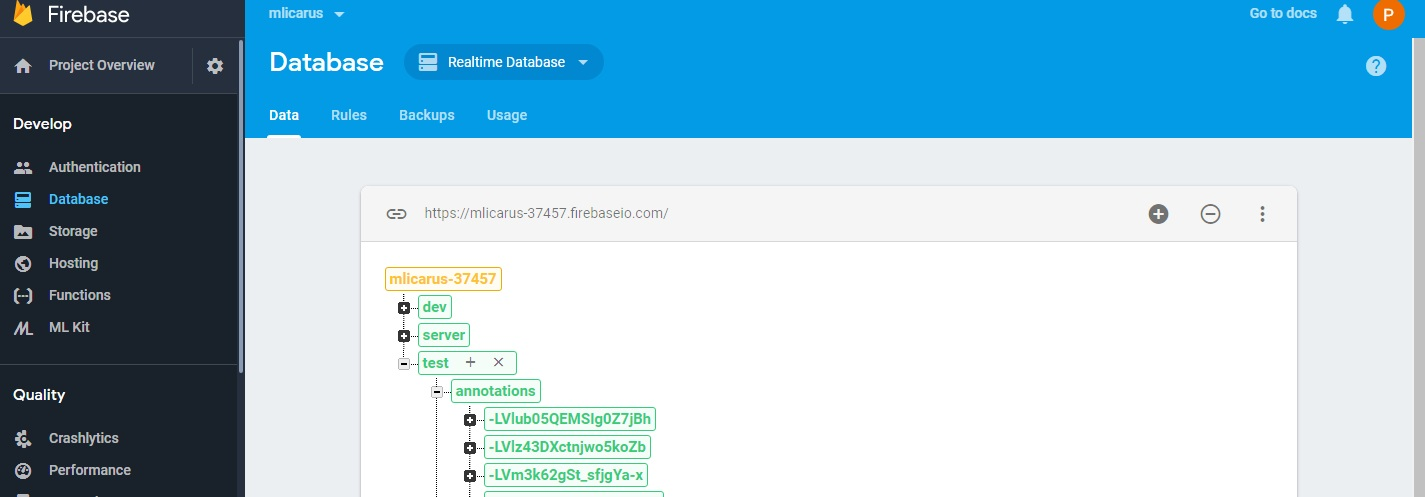

In [ ]:
db_dict = db.reference('test/annotations')#path to the annotations in database
querry_dict = db_dict.get()

k_list = list(querry_dict)#outputs list of annotation ids from output querry

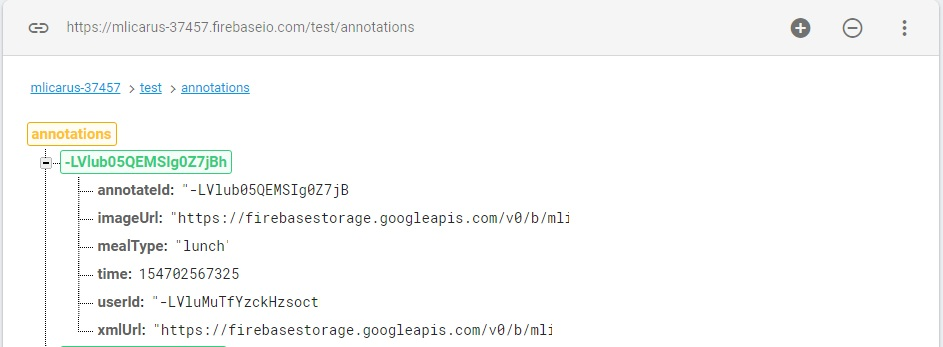

In [85]:
labels_firebase_db= ['imageUrl','xmlUrl']

df_urls = pd.DataFrame([[querry_dict[i][j] for j in labels_firebase_db] for i in k_list], columns=['imgurl','xmlurl'])
    
labels_ext_xml= ['xmin','ymin','xmax','ymax','name']#labels to be extracted from xml
df_urls.head(5)

,imgurl,xmlurl
0,https://firebasestorage.googleapis.com/v0/b/ml...,https://firebasestorage.googleapis.com/v0/b/ml...
1,https://firebasestorage.googleapis.com/v0/b/ml...,https://firebasestorage.googleapis.com/v0/b/ml...
2,https://firebasestorage.googleapis.com/v0/b/ml...,https://firebasestorage.googleapis.com/v0/b/ml...
3,https://firebasestorage.googleapis.com/v0/b/ml...,https://firebasestorage.googleapis.com/v0/b/ml...
4,https://firebasestorage.googleapis.com/v0/b/ml...,https://firebasestorage.googleapis.com/v0/b/ml...


### • Test parsing an xml through xml url from firebase db

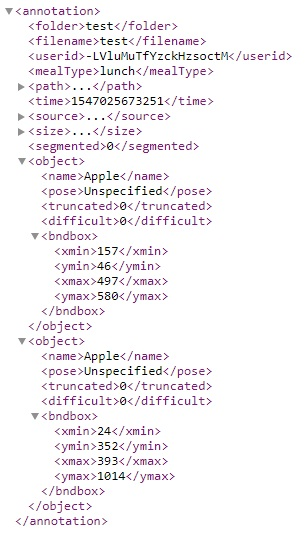

In [86]:
path =df_urls.xmlurl[0]#'https://firebasestorage.googleapis.com/v0/b/mlicarus-37457.appspot.com/o/test%2FannotationXmls%2F-LVluMuTfYzckHzsoctM-1547025673251-annotate.xml?alt=media&token=4cfce88a-63f6-4ff0-b2bd-e493d8871947' #contains data as list
file = urllib.request.urlopen(path)
data= file.read()
xmltodict.parse(data)['annotation']

OrderedDict([('folder', 'test'),
             ('filename', 'test'),
             ('userid', '-LVluMuTfYzckHzsoctM'),
             ('mealType', 'lunch'),
             ('path',
              'https://firebasestorage.googleapis.com/v0/b/mlicarus-37457.appspot.com/o/test%2FannotationImages%2F-LVluMuTfYzckHzsoctM-1547025673251-annotate.jpg?alt=media&token=5b1ea3f7-1bd5-4d33-8525-1b588d6ca8d2'),
             ('time', '1547025673251'),
             ('source', OrderedDict([('database', 'Unknown')])),
             ('size',
              OrderedDict([('width', '720'),
                           ('height', '1112'),
                           ('depth', '3')])),
             ('segmented', '0'),
             ('object',
              [OrderedDict([('name', 'Apple'),
                            ('pose', 'Unspecified'),
                            ('truncated', '0'),
                            ('difficult', '0'),
                            ('bndbox',
                             OrderedDict([('xmin',

In [87]:
xmltodict.parse(data)['annotation']['object']

[OrderedDict([('name', 'Apple'),
              ('pose', 'Unspecified'),
              ('truncated', '0'),
              ('difficult', '0'),
              ('bndbox',
               OrderedDict([('xmin', '157'),
                            ('ymin', '46'),
                            ('xmax', '497'),
                            ('ymax', '580')]))]),
 OrderedDict([('name', 'Apple'),
              ('pose', 'Unspecified'),
              ('truncated', '0'),
              ('difficult', '0'),
              ('bndbox',
               OrderedDict([('xmin', '24'),
                            ('ymin', '352'),
                            ('xmax', '393'),
                            ('ymax', '1014')]))])]

###  • To Extract relevnt details, parsing all the xmls at once

In [74]:
def parsexml(df_urls,labels):
    '''
    This parses the xmlUrl to output select contents of xml files.
    
    input arg:
    df_urls: dataframe holding imgUrls & xmlUrls to xml annotations.
    labels: lables to be extracted from xml file @url, i.e [xmin, ymin, xmax, ymax, name].
    
    return:
    dataframe of combined string vals of image_url,xmin,ymin,xmax,ymax,class_name; as 'https://url.jpg,12,15,16,18,pizza'.
    
    '''    
    records = []
    for idx, url in enumerate(df_urls.xmlurl):
        file = urllib.request.urlopen(url)
        data= file.read()
        data= xmltodict.parse(data)['annotation']['object']# annotation and object are common & irrelavant folder for traversing
        if type(data) is not list:#when annotation holds only 1 object, i.e as orderedDict
            data = [data] #add it to a list
        #following appends coordinates +name each of the multiple objects in image xml alongside imageUrl        
        records= records+ [df_urls.imgurl[idx] + ',' +','.join([data[n]['bndbox'][lbl] for lbl in labels[:-1]])+ ',' + data[n][labels[-1]] for n in range(len(data))]
    
    df_x=pd.Series(records)
    return df_x

#folllowing line combines all above and horizontal list traversing method
#df_x =pd.DataFrame([df_urls.imgurl[idx] + ',' + ','.join([xmltodict.parse(urllib.request.urlopen(path).read())['annotation']['object']['bndbox'][n] for n in labels[:-1]])+ ',' +xmltodict.parse(urllib.request.urlopen(path).read())['annotation']['object'][labels[-1]] for path in df_xml.xmlurl], columns='details')

###  • Following generates required annotations file through parsed xmls

In [78]:
def generate_annotations(ref_path):
    '''
    input arg:
    ref_path: firebase reference path to annotation database

    Output:
    df_b: a dataframe constituting records of form 'https://apple.jpg,52,57,426,523,Apple'
    thus generates a text file encompassing details of all images.
    
    '''   
    ref = db.reference(ref_path)
    querry_dic = ref.get()
    k_list = list(querry_dic)#outputs list of annotation ids from output querry

    labels_firebase_db= ['imageUrl','xmlUrl']#add lables to extract from db later, like xmin,ymin, class_name values when they're put out of xml 

    df_urls = pd.DataFrame([[querry_dic[i][j] for j in labels_firebase_db] for i in k_list], columns=['imgurl','xmlurl'])# for i in k_list])
    
    labels_ext_xml= ['xmin','ymin','xmax','ymax','name']#label names to be extracted from xml
    
    df_txt = parsexml(df_urls, labels_ext_xml)
    
    #df_b['details'] = df_a.imgurl+ ',' + df_b.details #new dataframe combined to give required format output
    
    
    df_txt.to_csv('annotations_firebase.txt', header=None, index=None, sep=' ')#saves dataframe as annotations.txt file
    
    print('complete')
    

In [90]:
df_txt = parsexml(df_urls, labels_ext_xml)
df_txt[0]

'https://firebasestorage.googleapis.com/v0/b/mlicarus-37457.appspot.com/o/test%2FannotationImages%2F-LVluMuTfYzckHzsoctM-1547025673251-annotate.jpg?alt=media&token=5b1ea3f7-1bd5-4d33-8525-1b588d6ca8d2,157,46,497,580,Apple'

###  • Saving annotations file

In [79]:
import time
t= time.time()
ref_path = 'test/annotations'
generate_annotations(ref_path)

print('tot time:', time.time()-t)

complete
tot time: 44.20252823829651


### ♦ Or Alternatively
#### Dicard use of xmlUrl for parsing xml, insted save all relevant label values which are otherwise stored in xml, outside as child nodes with 'imageUrl' as:

labels2extract= ['imgurl', 'ymin', 'ymin', 'xmax', 'yamx', 'class_name']

db_series= pd.Series([','.join([querry_dict[i][j] for j in labels2extract]) for i in k_list])

db_series.head(3)

print(db_series[0])

db_series.to_csv('')

###### • _For Example with existing nodes at same level_
labels2extract =['annotateId','imageUrl','mealType','xmlUrl']


In [34]:
labels2extract =['annotateId','imageUrl','mealType','xmlUrl']
db_series= pd.Series([','.join([querry_dict[i][j] for j in labels2extract]) for i in k_list])
print(db_series.head(4))
print('\n',db_series[0])
#db_series.to_csv('annotations_firebase.txt')

0    -LVlub05QEMSIg0Z7jBh,https://firebasestorage.g...
1    -LVlz43DXctnjwo5koZb,https://firebasestorage.g...
2    -LVm3k62gSt_sfjgYa-x,https://firebasestorage.g...
3    -LVmRzUswD71p4ycxChI,https://firebasestorage.g...
dtype: object

 -LVlub05QEMSIg0Z7jBh,https://firebasestorage.googleapis.com/v0/b/mlicarus-37457.appspot.com/o/test%2FannotationImages%2F-LVluMuTfYzckHzsoctM-1547025673251-annotate.jpg?alt=media&token=5b1ea3f7-1bd5-4d33-8525-1b588d6ca8d2,lunch,https://firebasestorage.googleapis.com/v0/b/mlicarus-37457.appspot.com/o/test%2FannotationXmls%2F-LVluMuTfYzckHzsoctM-1547025673251-annotate.xml?alt=media&token=4cfce88a-63f6-4ff0-b2bd-e493d8871947
